## Run preprocessed Data through a Model that predicts the identity: 
## See if we can make a more detailed analysis.

In [ ]:
#!pip install transformers tqdm

import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from tqdm import tqdm 

In [ ]:
file_path = '/content/preprocessed_df_1%_data.tsv'

try:
    toxicity_analysis_df = pd.read_csv(file_path, sep="\t")  
except Exception as e:
    print(f"Error loading file: {e}")

In [ ]:
toxicity_analysis_df

In [ ]:
# Load a pre-trained model and tokenizer
model_name = "distilbert-base-uncased"  # You can choose another model as well
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=8)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define your identity labels
identity_labels = [
    "male",
    "female",
    "homosexual_gay_or_lesbian",
    "christian",
    "jewish",
    "muslim",
    "black",
    "white",
    "psychiatric_or_mental_illness"
]

# Function to predict identities for a batch of texts
def predict_identities_batch(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    
    # Move inputs to GPU if available
    if torch.cuda.is_available():
        inputs = {key: val.to('cuda') for key, val in inputs.items()}
        model.to('cuda')

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Apply sigmoid to get probabilities
    probabilities = torch.sigmoid(logits).tolist()
    return probabilities

# Set the batch size
batch_size = 32  # Adjust based on GPU memory

# Initialize a list to store the results
identity_results = []

# Process the DataFrame in batches
for i in tqdm(range(0, len(toxicity_analysis_df), batch_size), desc="Processing Identity Predictions"):
    batch_texts = toxicity_analysis_df['preprocessed'].iloc[i:i + batch_size].tolist()
    batch_results = predict_identities_batch(batch_texts)
    identity_results.extend(batch_results)

results_df = pd.DataFrame(identity_results, columns=identity_labels)
final_df = pd.concat([toxicity_analysis_df, results_df], axis=1)

In [5]:
import pandas as pd

file_path = f'..\\resources\\preprocessed_df_detailed.tsv'

try:
    detailed_toxicity_analysis_df = pd.read_csv(file_path, sep="\t")  
except Exception as e:
    print(f"Error loading file: {e}")

In [6]:
detailed_toxicity_analysis_df

,subreddit_category,word_count,preprocessed,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,Advice,228,"i 'm 23 , moved back in with parents . how do ...",0.040027,0.000653,0.028208,0.000394,0.003589,0.000646
1,Advice,143,always feel an overwhelming lack of confidence...,0.000605,0.000129,0.000194,0.000133,0.000169,0.000142
2,Advice,233,"dealing with this break up hey there , this mo...",0.030998,0.000231,0.002992,0.000312,0.001874,0.000386
3,Advice,398,disagreement when picking rooms in the new hou...,0.001222,0.000104,0.000211,0.000113,0.000194,0.000151
4,Advice,226,i do n't know what i believe i do n't typicall...,0.002152,0.000106,0.000291,0.000116,0.000206,0.000158
...,...,...,...,...,...,...,...,...,...
1144,travel,213,"traveling , a few questions , ( planning a tri...",0.001018,0.000104,0.000187,0.000109,0.000183,0.000146
1145,weddingplanning,280,"wedding blanket ? i 'm a plus size bride , wit...",0.001532,0.000104,0.000241,0.000113,0.000190,0.000149
1146,weddingplanning,336,"36 days to go , & i ca n't find my english bir...",0.014613,0.000298,0.006454,0.000258,0.001079,0.000310
1147,weddingplanning,301,making your own wedding invitations ... is it ...,0.005515,0.000115,0.000559,0.000154,0.000365,0.000202


In [7]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency, boxcox, yeojohnson
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))

def show_wordcloud(data, title=None):
    sns.set(style="whitegrid")  

    text_data = ' '.join(data['preprocessed'].dropna())

    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords_set,  
        max_words=50,
        max_font_size=40,
        scale=5,
        random_state=1
    ).generate(text_data)

    fig = plt.figure(1, figsize=(10, 10))
    plt.axis('off')
    
    if title:
        fig.suptitle(title, fontsize=20, style='italic')
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sinaj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


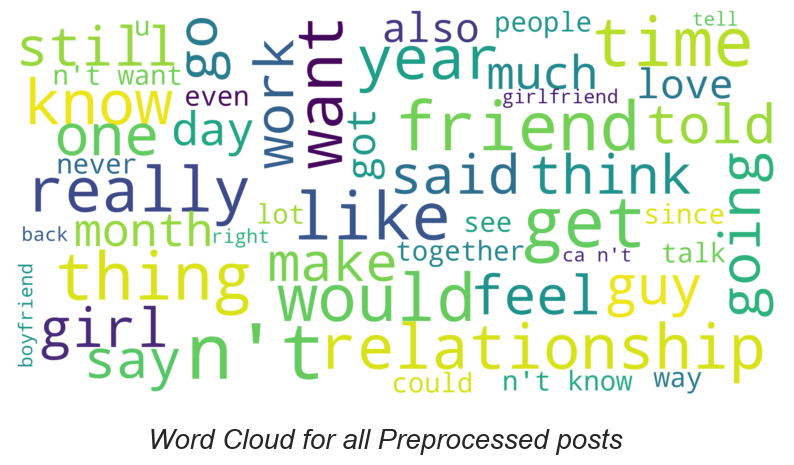

In [8]:
show_wordcloud(detailed_toxicity_analysis_df, title="Word Cloud for all Preprocessed posts")

In [12]:
average_values = detailed_toxicity_analysis_df[['severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']].mean()
highest_values = detailed_toxicity_analysis_df[['severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']].max()


print(average_values)
highest_values

severe_toxicity    0.080118
obscene            0.002215
threat             0.070065
insult             0.001112
identity_attack    0.017538
sexual_explicit    0.002019
dtype: float64


severe_toxicity    0.996837
obscene            0.298645
threat             0.982429
insult             0.174265
identity_attack    0.932756
sexual_explicit    0.297033
dtype: float64

In [13]:
average_values = {
    'severe_toxicity': 0.080118,
    'obscene': 0.002215,
    'threat': 0.070065,
    'insult': 0.001112,
    'identity_attack': 0.017538,
    'sexual_explicit': 0.002019
}

filtered_df = detailed_toxicity_analysis_df[
    (detailed_toxicity_analysis_df['severe_toxicity'] >= average_values['severe_toxicity']) &
    (detailed_toxicity_analysis_df['obscene'] >= average_values['obscene']) &
    (detailed_toxicity_analysis_df['threat'] >= average_values['threat']) &
    (detailed_toxicity_analysis_df['insult'] >= average_values['insult']) &
    (detailed_toxicity_analysis_df['identity_attack'] >= average_values['identity_attack']) &
    (detailed_toxicity_analysis_df['sexual_explicit'] >= average_values['sexual_explicit'])
]

filtered_df

,subreddit_category,word_count,preprocessed,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
9,Advice,310,i caught my best friend smelling my dirty unde...,0.498230,0.004765,0.442264,0.001510,0.031854,0.003098
22,AskReddit,189,"reddit , my dad has been calling the past 2 da...",0.135708,0.003576,0.210396,0.001162,0.035543,0.003611
29,AskReddit,130,what is the weirdest non - sexual event that h...,0.485334,0.004543,0.412932,0.002620,0.046887,0.003321
34,AskReddit,200,recently told a chick i would n't have sex wit...,0.549427,0.004708,0.332067,0.002706,0.054267,0.006776
37,AskReddit,335,a cop once caught me pooping on the side of th...,0.902617,0.040825,0.863608,0.020237,0.260177,0.018396
...,...,...,...,...,...,...,...,...,...
1131,tifu,329,tifu by possibly losing my new job . this actu...,0.741740,0.008130,0.682581,0.001640,0.115967,0.004086
1132,tifu,368,tifu by thinking someone was going to rob me (...,0.191386,0.003191,0.123276,0.002770,0.030185,0.012278
1137,tifu,331,tifu by not completing my sentence .... this h...,0.959471,0.089025,0.898208,0.110573,0.492575,0.027273
1138,tifu,223,tifu by checking my girlfriend fb photos this ...,0.725453,0.011881,0.733224,0.001924,0.220762,0.006887


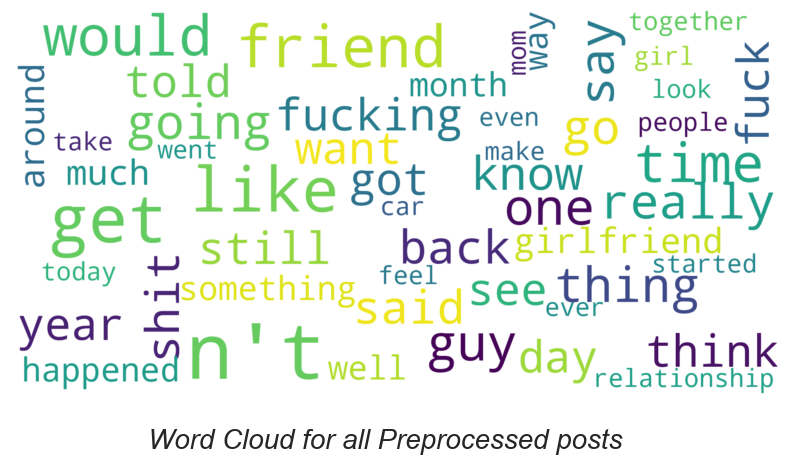

In [14]:
show_wordcloud(filtered_df, title="Word Cloud for all Preprocessed posts")

In [19]:
toxicity_columns = ['severe_toxicity']
toxicity_higher = filtered_df[(filtered_df[toxicity_columns] > 0.5).all(axis=1)]



In [26]:
toxicity_higher.head()

,subreddit_category,word_count,preprocessed,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
34,AskReddit,200,recently told a chick i would n't have sex wit...,0.549427,0.004708,0.332067,0.002706,0.054267,0.006776
37,AskReddit,335,a cop once caught me pooping on the side of th...,0.902617,0.040825,0.863608,0.020237,0.260177,0.018396
51,AskReddit,139,what are some crazy/ strange things your grand...,0.636991,0.006440,0.629174,0.001580,0.103951,0.004105
66,AskReddit,301,i just had a girl i 'm seeing pretend to be he...,0.633658,0.006734,0.460028,0.001872,0.329306,0.011331
75,AskReddit,238,did i tip really too much ? being gay and pret...,0.580944,0.011394,0.463516,0.004566,0.164194,0.051952


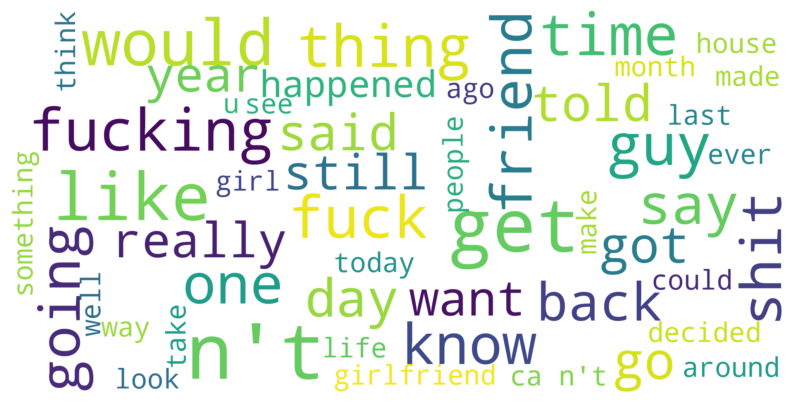

In [27]:
show_wordcloud(toxicity_higher)

In [36]:
toxicity_columns = ['severe_toxicity']
toxicity_higher = filtered_df[(filtered_df[toxicity_columns] > 0.9).all(axis=1)]

In [38]:
toxicity_higher

,subreddit_category,word_count,preprocessed,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
37,AskReddit,335,a cop once caught me pooping on the side of th...,0.902617,0.040825,0.863608,0.020237,0.260177,0.018396
181,BreakUps,209,ex is sleeping around my fraternity ... after ...,0.969977,0.072647,0.947676,0.009956,0.391280,0.012879
295,offmychest,242,"fucking people ugh well , this started today w...",0.983760,0.074194,0.967239,0.001770,0.269901,0.002999
298,offmychest,234,plur bitch back story so this girl whose an ac...,0.996837,0.298645,0.982429,0.006042,0.932756,0.297033
554,relationships,374,"im[f/25 ] fucking up , and i really need some ...",0.968381,0.054062,0.955010,0.002014,0.181760,0.003221
562,relationships,315,am i in the wrong ? me ( 20 m ) and my gf(24 )...,0.902309,0.029416,0.861737,0.002331,0.591836,0.012187
797,relationships,297,how do i get past my dick ? i [ m28 ] was dump...,0.915201,0.020975,0.866615,0.001574,0.093062,0.002823
984,relationships,284,my [ 27 / m ] girlfriend [ 19 / f ] needs seri...,0.935951,0.066884,0.796930,0.174265,0.400715,0.045842
1058,self,388,just a story about an ex that i had to get off...,0.967641,0.074854,0.944570,0.014767,0.490605,0.011821
1062,self,371,a thought crossed my mind last night ... as i ...,0.921922,0.056763,0.905298,0.029905,0.253211,0.012469


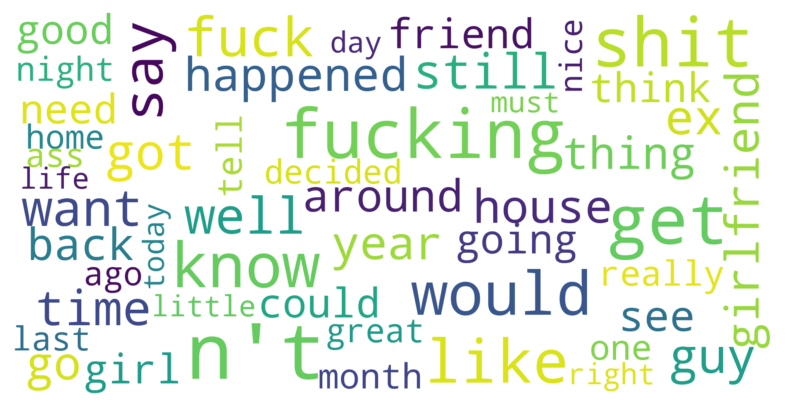

In [39]:
show_wordcloud(toxicity_higher)

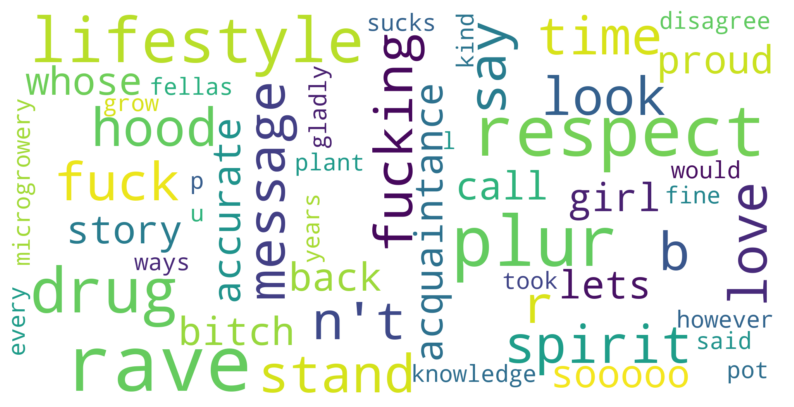

In [42]:
toxicity_columns = ['identity_attack']
toxicity_higher = filtered_df[(filtered_df[toxicity_columns] > 0.9).all(axis=1)]

show_wordcloud(toxicity_higher)